<a href="https://colab.research.google.com/github/goekalph/My-Projects/blob/main/Neural_tree_based_models_for_TS_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IS Seminar WS 23/24

Prototype: Neural Tree-based Models for Time Series forecasting

Submitted By: Hasan Mert Gökalp, Oliver Klatt Tustanowski, Zhuocheng Xie, Bhavya Goyal

#Table of Contents
1  Introduction

2  Literature Review

3  Experimental Design

4  Methodology

5  Optimization

6  Conclusion

7  References

# Importing Libraries

In [ ]:
#Import the libraries
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import random

#Deep Neural Networks
from tensorflow import keras
from tensorflow.keras import layers

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# 1. Introduction



---



#### 1.1 Why Time Series?

Time Series Forecasting is an important art of machine learning with applications in the fields such as finance, energy and climate modeling. High-dimensional time series involve complex relationships and interactions among variables. Neural networks and decision trees ensemble models are both prominent classes of machine learning models widely applied to time series forecasting, where they have demonstrated incredible results.

#### 1.2 Why Neural Based Models?

Neural networks are characterized for their ability
to learn hierarchical data representations by applying sequences of non-linear transforma-
tions. In addition neural network models are differentiable, allowing us to use techniques like back propagation with gradient descent or stochastic gradient descent (SGD). With
these methods the weights and biases of the model can be optimized efficiently even on
large data sets.

#### 1.3 Why Tree Based Models?
Tree-Based Models learn by recursively splitting the feature space and aiming to minimize some sort of impurity within the child nodes, so that linear models will be sufficient to explain these subsets of data.


#### 1.4 Our Contribution
In the Prototype, we explore a neural-tree based model for time-series forecasting. Besides, we compare and extend of existing neural tree based models in forecasting. Also we will summarise their performance and dis- and advantages.

#2 Literature Review

...

# 3 Experimental Design

This section gives an overview of the dataset of weather time series dataset, which is recorded by `the Max Planck Institute for Biogeochemistry` and included in Tensorflow. Moreover, the data was recorded by every 10 mintues with 14 features, beginning from 2003. For efficiency, we only use the data between 2009 and 2016. We chose the data because it has periodicity and doesn't affect by many immeasurable factor.We do some exploratory data analysis and prepare the dataset.

## 3.1 Exploratory Data Analysis & Data Organization

Here shows the first five rows of the data and we prefer to train and predict them hourly. So we changed the intervals from 10 mintues to one hours.

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 [==============================] - 0s 0us/step


In [ ]:
df = pd.read_csv(csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record. This is to make the frequency of data every one hour.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Here the changes of some features by time can be seen.

For the first three graphs, they show the changes in the whole timeline when others three show the changes in twenty days from Jan.2. to Jan. 21. in 2009. As you can see, temperature changed periodly.

Temperatures reached their highest in the middle and lowest in the begining as well as end of each year. There were significant lowest at the begining of 2009 and 2012. As for the 20 days data, there were no trend of temperature, but between Jan.7 to Jan.13 it became warmer steadily.


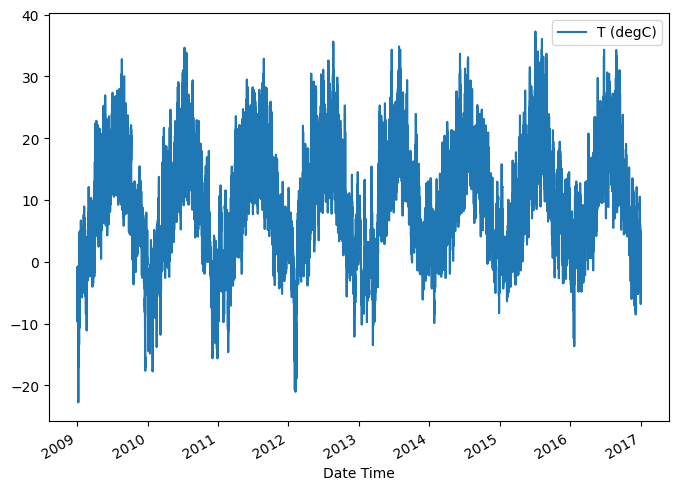

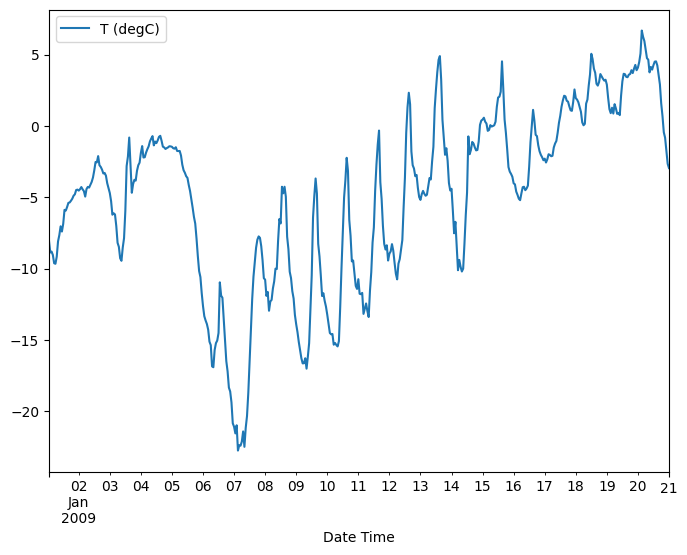

In [ ]:
plot_cols = ['T (degC)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

## 3.2 Data Preprocessing
In this part, we did feature engineering and data split as preparation for training neural networks.

### 3.2.1 Feature Engineering
Here we combine wind direction with wind velocity and clean the errors by changing the `min` and `max`.

In [ ]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

For easier interpretation, we convert the wind direction and velocity columns to a wind vector.

In [ ]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

The time in seconds is not a good model input. Considering weather data, it has daily and yearly periodicity, thus, we converted Datetime columns into sin and cos functions for the day and year.

In [ ]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Here we split the data to training, validation and test with 70%, 20% and 10%.

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

Before training a neural network, we scaled the data by normalization. Here we used simple average.

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

### 3.2.2 Data windowing
We predicted a set of data based on a window of consecutive samples. So in the following code, we defined a class of window generator, which includes:

1. Handling the indexes and offsets.
2. Splitting windows, which converts the list of consecutibe inputs to a window of inputs and labels.
3. Create an example plot.
4. Create training, validation and test Dataset.

In [ ]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
          self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]

        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes manually.
        # This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
# Create An Example Plot
    def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')
# Create Training, Validation Test Dataset
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=False,
            batch_size=32)

        ds = ds.map(self.split_window)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result


We created two windows， `w1` shows a single prediction 24 hours into the future, given 24 hours of history. `w2` shows a prediction one hour into the future, given six hours of history.

In [ ]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [ ]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

Lets take a look into train dataset

In [ ]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [ ]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


Forecasting 1 hour into the future given the values of last 3 hour.

In [ ]:
three_step_window = WindowGenerator(
    input_width=3, label_width=1, shift=1,
    label_columns=['T (degC)'])
three_step_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Forecasting 1 hour into the future given the values of last 24 hour.

In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=1, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['T (degC)']

This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to.

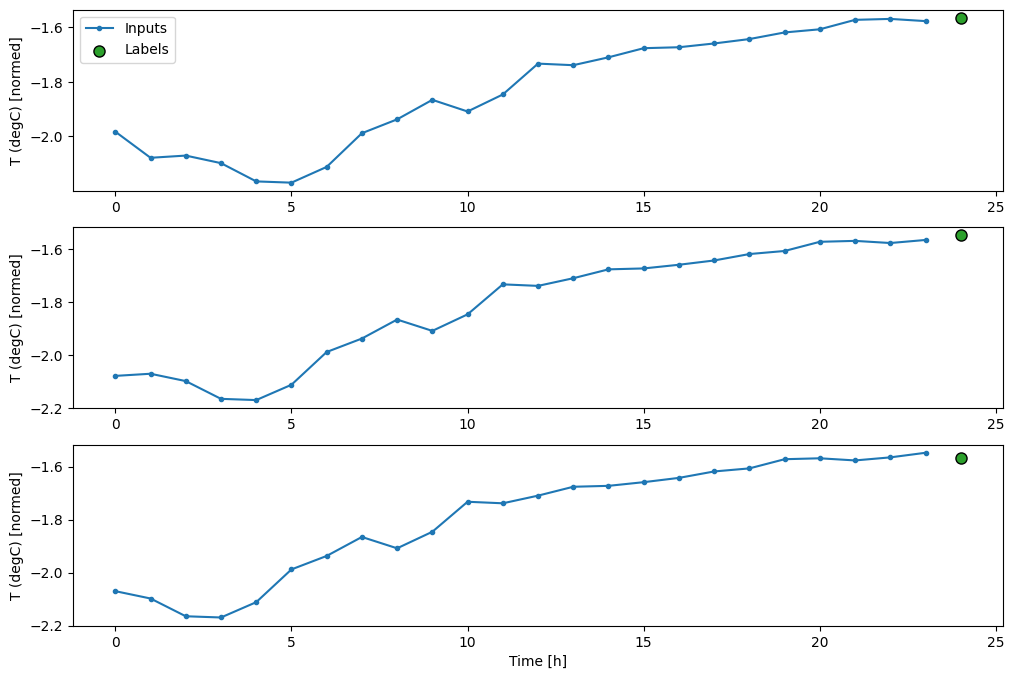

In [ ]:
wide_window.plot()

# 4 Methodology
In this part, we will introduce the prototype of our model inspired by Deep Neural Decision Forest model introduced by P. Kontschieder. In an effort to refine the existing model, we're implementing a more advanced strategy that involves creating distinct neural networks for decision parameters at each level of the tree and sampling features uniquely for each node. This is a departure from the original design, where a single neural network was used for all decision parameters and feature sampling was conducted only once for all nodes.






## 4.1 Deep Neural Decision Tree for Time Series

The model is initialized with parameters like tree depth, number of features, used features rate, and output size. Output size determines the number of time steps to predict.
The depth of the tree determines the number of levels and the total number of leaves. The forward pass of the model works as follows:

1. Input Features and Initialization:

 The model is designed to process batches of time series data. Each input instance to the model should be a 3D tensor where the dimensions represent:

- Batch Size: This dimension represents the number of time series sequences in a single batch. (represented as None)

- Time Steps: This dimension also can be variable (represented as None). It corresponds to the length of the time series, i.e., the number of time points in each sequence.

- Number of Features: This is the number of features from the dataset.

The model generates a variable pi for leaf values initialization.
2. Feature Masking:

At each node, a used_features_mask is applied to randomly select a subset of the input features. This is to ensure that different features are used at different nodes, introducing variability in the decision process.
3. Building Decision Functions:

The model dynamically creates decision functions for each level of the tree, choosing between LSTM and CNN layers randomly for each level.
Additional elements like dropout layers and global average pooling (for CNN paths) are added to enhance the model's capability to generalize.

4. Routing Through the Tree:

For each level of the tree, the model computes decisions(probabilities) for the left and right paths at each node.
It involves applying the feature mask to the input features and then feeding these masked features into the respective decision functions (LSTM or CNN layers).
The outputs of these functions determine the path (left or right) that each instance in the batch will take at the current node.
These values are then updated based on the decisions made at each level, effectively guiding the instances through the tree. At the end mu values, which represent the probabilities for instances to reach the tree leaves, are found by iteratively performing stochastic routing through the tree levels.
5. Final Output Calculation:

After traversing all levels,
the model computes the final output by matrix-multiplying the mu values(probabilities) with the forecasting values at leaf nodes (pi).


- Note: Minimum number of 3 time steps are required because of the CNN layer.

In [ ]:

class NeuralDecisionTreeForTimeSeries(keras.Model):
    def __init__(self, depth,
                 num_features,
                 used_features_rate,
                 output_size):
        super().__init__()
        self.depth = depth
        self.num_leaves = 2 ** depth
        self.output_size = output_size

        # Create a mask for the randomly selected features.
        self.num_features = num_features
        self.used_features_rate = used_features_rate

        # Leaf values initialization for forecasting
        self.pi = tf.Variable(initial_value=tf.random_normal_initializer()(shape=[self.num_leaves, self.output_size]),
                              dtype='float32', trainable=True)

        self.decision_functions = {} # Dictionary to store decision models

        activation_functions = ['relu', 'tanh', 'gelu', 'elu'] #SELU REQUIRES SPECIFIC WEIGHTS INITIALIZATION!
        initial_size = 64  # Initial number of units/filters 'REDUCE THE HIDDEN SIZE!'
        min_size = 16  # Minimum number of units/filters
        for i in range(self.depth):
            # Calculate the size for this depth
            layer_size = max(min_size, initial_size // (2 ** i))
            # Randomly choose an activation function
            activation_function = random.choice(activation_functions) #OPTUNA!

            # Randomly choose between LSTM and CNN for this level
            if random.choice(['LSTM','CNN']) == 'LSTM':
                first_layer = tf.keras.layers.LSTM(layer_size, return_sequences=False)
                #WHEN SAMPLING WITH OPTUNA: each tree either with CNN or LSTM, or both, TO TEST!
                #IN EACH HIDDEN LAYER: TUNE L1 & L2 REGULARIZATION1
                use_global_avg_pooling = False
            else:
                first_layer = tf.keras.layers.Conv1D(filters=layer_size, kernel_size=3, activation=activation_function)
                use_global_avg_pooling = True

            # Create Sequential models for left and right
            model_left = tf.keras.models.Sequential([first_layer])
            model_right = tf.keras.models.Sequential([first_layer])

            model_left.add(tf.keras.layers.Dropout(0.2))
            model_right.add(tf.keras.layers.Dropout(0.2))
            # Add GlobalAveragePooling layer conditionally for CNN
            if use_global_avg_pooling:
                model_left.add(tf.keras.layers.GlobalAveragePooling1D())
                model_right.add(tf.keras.layers.GlobalAveragePooling1D())

            # Add the final Dense layer
            model_left.add(tf.keras.layers.Dense(units=2**i, activation='linear'))
            model_right.add(tf.keras.layers.Dense(units=2**i, activation='linear'))

            # Store the models
            self.decision_functions[f'decision_fn_{i}_left'] = model_left
            self.decision_functions[f'decision_fn_{i}_right'] = model_right

    @tf.function
    def call(self, features):
        batch_size = tf.shape(features)[0]

        num_used_features = int(self.num_features * self.used_features_rate)
        one_hot = np.eye(num_features)
        mu = tf.ones([batch_size, 1, 1])


        # Traverse the tree in breadth-first order.
        for level in range(self.depth):
            decisions_left_all_nodes = []
            decisions_right_all_nodes = []
            # Get models for the current level
            model_left = self.decision_functions[f'decision_fn_{level}_left']
            model_right = self.decision_functions[f'decision_fn_{level}_right']
            # Process each node at the current level
            for node in range(2 ** level):
                # Sample different features for each node
                sampled_feature_indices = np.random.choice(
                    np.arange(self.num_features), num_used_features, replace=False)
                used_features_mask = one_hot[sampled_feature_indices]

                # Apply the feature mask to the input features
                sampled_features = tf.matmul(features, used_features_mask, transpose_b=True)

                # Compute decisions for left and right paths for the current node
                decisions_left_node = model_left(sampled_features)[:, node]
                decisions_right_node = model_right(sampled_features)[:, node]

                # Add an extra dimension to make each tensor 2D ([None] -> [None, 1])
                decisions_left_node_2d = tf.expand_dims(decisions_left_node, -1)
                decisions_right_node_2d = tf.expand_dims(decisions_right_node, -1)

                # Store the expanded tensors
                decisions_left_all_nodes.append(decisions_left_node_2d)
                decisions_right_all_nodes.append(decisions_right_node_2d)

            # Combine decisions from all nodes at the current level
            decisions_left = tf.concat(decisions_left_all_nodes, axis=1)
            decisions_right = tf.concat(decisions_right_all_nodes, axis=1)

            # Stack and apply softmax
            decisions = tf.stack([decisions_left, decisions_right], axis=-1)
            decisions = tf.nn.softmax(decisions, axis=-1)

            # Reshape and tile mu to match the current level's shape
            mu = tf.reshape(mu, [batch_size, -1, 1])  # [batch_size, 2 ** (level-1), 1]
            mu = tf.tile(mu, (1, 1, 2))  # [batch_size, 2 ** (level-1), 2]

            # Multiply mu by decisions to update probabilities
            mu = mu * decisions

        mu = tf.reshape(mu, [batch_size, self.num_leaves])  # [batch_size, num_leaves]
        predictions_for_leaves = self.pi  # [num_leaves, num_outputs]
        outputs = tf.matmul(mu, predictions_for_leaves)  # [batch_size, num_outputs]
        outputs=tf.reshape(outputs, [batch_size, self.output_size, 1])
        return outputs

# Class for the forest model

This is not ready for the prototype. In the future we will use a forest to make predicitons instead of one tree.

In [ ]:

class NeuralDecisionForest(keras.Model):
    def __init__(self, num_trees, depth, num_features, used_features_rate, output_size):
        super().__init__()
        self.ensemble = []
        # Initialize the ensemble by adding NeuralDecisionTree instances.
        # Each tree will have its own randomly selected input features to use.
        for _ in range(num_trees):
            self.ensemble.append(
                NeuralDecisionTreeForTimeSeries(depth, num_features, used_features_rate, output_size)
            )

    def call(self, inputs):
        # Initialize the outputs: a [batch_size, output_size] matrix of zeros.
        batch_size = tf.shape(inputs)[0]
        outputs = tf.zeros([batch_size, output_size,1])

        # Aggregate the outputs of trees in the ensemble.
        for tree in self.ensemble:
            outputs += tree(inputs)
        # Divide the outputs by the ensemble size to get the average.
        outputs /= len(self.ensemble)
        return outputs


####Lets do some experiments!

1. First create an instance of our class with depth=3

2. Then we need to initialize the weights in our model using the function build and specifying the input shape

In the prototype we will predict only 1 time step at a time, this will change in the future.


In [ ]:
num_features=df.shape[1]
used_features_rate=0.4
output_size=1
tree = NeuralDecisionTreeForTimeSeries(depth=3,
                                       num_features=num_features,
                                       used_features_rate=used_features_rate,
                                       output_size=output_size)


In [ ]:
tree.build(input_shape=(None,None,num_features))

Lets take a look at the architecture

In [ ]:
tree.summary()

Model: "neural_decision_tree_for_time_series"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 1)                 1473      
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1473      
                                                                 
 sequential_2 (Sequential)   (None, 2)                 5186      
                                                                 
 sequential_3 (Sequential)   (None, 2)                 5186      
                                                                 
 sequential_4 (Sequential)   (None, 4)                 1604      
                                                                 
 sequential_5 (Sequential)   (None, 4)                 1604      
                                                                 
Total params: 8470 (33.09 KB)


# 5 Custom Training Loop

1. Lets create a custom training loop for optimizing the weights in our model. In this loop we will perform two step optimization
 - First optimize the leaf node parameters while fixing decision parameters.
 - Then optimize the decision parameters while fixing leaf node parameters.
 - Continue doing this in loop for a specified number of epochs


In [ ]:
@tf.function
def train_step_pi(model, x, y, optimizer, loss_fn, metric):
    with tf.GradientTape() as tape:
        predictions = model(x, training=True)
        loss = loss_fn(y, predictions)
    grads = tape.gradient(loss,[model.trainable_variables[-1]])
    optimizer.apply_gradients(zip(grads, [model.trainable_variables[-1]]))
    metric.update_state(y, predictions)
    return loss

@tf.function
def train_step_mu(model, x, y, optimizer, loss_fn, metric):
    with tf.GradientTape() as tape:
        predictions = model(x, training=True)
        loss = loss_fn(y, predictions)
    grads = tape.gradient(loss, model.trainable_variables[:-1])
    optimizer.apply_gradients(zip(grads, model.trainable_variables[:-1]))
    metric.update_state(y, predictions)
    return loss

@tf.function
def val_step(model, x, y, loss_fn, loss_metric):
    val_predictions = model(x, training=False)
    loss = loss_fn(y, val_predictions)
    loss_metric.update_state(y, val_predictions)
    return loss

In [ ]:
def custom_train_model(model, window, num_epochs, optimizer, loss_fn):
    metric = tf.keras.metrics.MeanAbsoluteError()
    optimizer.build(model.trainable_variables)
    for epoch in range(num_epochs):

        print(f"Epoch {epoch+1}/{num_epochs}")

        # First loop for updating π (variable_pi)
        for step, (x_batch_train, y_batch_train) in enumerate(window.train):
            loss_value = train_step_pi(model, x_batch_train, y_batch_train, optimizer, loss_fn, metric)
            if step % 200 == 0:
                print(f"Updating π - Loss at step {step}: {float(loss_value)}")
        train_acc = metric.result()
        metric.reset_states()
        print("train_mean_absolute_error: %.4f" % (float(train_acc),))
        # Second loop for updating μ (variable_mu)
        for step, (x_batch_train, y_batch_train) in enumerate(window.train):
            loss_value = train_step_mu(model, x_batch_train, y_batch_train, optimizer, loss_fn, metric)
            if step % 200 == 0:
                print(f"Updating μ - Loss at step {step}: {float(loss_value)}")
        train_acc = metric.result()
        metric.reset_states()
        print("train_mean_absolute_error: %.4f" % (float(train_acc),))
        # Validation loop at the end of each epoch
        for x_batch_val, y_batch_val in window.val:
            val_loss= val_step(model, x_batch_val, y_batch_val, loss_fn, metric)

        val_acc = metric.result()
        metric.reset_states()
        print("val_loss: %.4f" % (float(val_loss),))
        print("val_mean_absolute_error: %.4f" % (float(val_acc),))

        # Additional operations at the end of each epoch, if necessary


Define the optimizer and the loss function here. This cell needs be run everytime before experimenting with different trees. We set loss function as mean square error, optimizer as Adam optimization which is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments and output results in metrics.

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.MeanSquaredError()



In [ ]:
custom_train_model(tree, three_step_window, 10, optimizer, loss_fn)

Epoch 1/10
Updating π - Loss at step 0: 0.017410341650247574
Updating π - Loss at step 200: 0.004055861383676529
Updating π - Loss at step 400: 0.007415737025439739
Updating π - Loss at step 600: 0.007960077375173569
Updating π - Loss at step 800: 0.006105051375925541
Updating π - Loss at step 1000: 0.009051915258169174
Updating π - Loss at step 1200: 0.005938065703958273
Updating π - Loss at step 1400: 0.004453260451555252
train_mean_absolute_error: 0.0738
Updating μ - Loss at step 0: 0.003096628002822399
Updating μ - Loss at step 200: 0.00372694106772542
Updating μ - Loss at step 400: 0.006247404962778091
Updating μ - Loss at step 600: 0.008473655208945274
Updating μ - Loss at step 800: 0.005609448067843914
Updating μ - Loss at step 1000: 0.0068098995834589005
Updating μ - Loss at step 1200: 0.006379884202033281
Updating μ - Loss at step 1400: 0.0037162359803915024
train_mean_absolute_error: 0.0730
val_loss: 0.0017
val_mean_absolute_error: 0.0626
Epoch 2/10
Updating π - Loss at step 

KeyboardInterrupt: ignored

## Hyperparameter Tuning

Hyperparameter tuning for depth of the tree will be done using Optuna in the future. Optuna will also be used to sample activation functions and different time series processing layers

# 6 Conclusion

# 7 References